# Human Segmentation Inference Example

### Import modules

In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import src.segmentation.config as cfg
from src.segmentation.model_deeplabv3 import deeplabv3
from src.segmentation.lightning_file import HumanSegmentation
from torchvision.transforms.functional import to_pil_image

### Load model for inference

In [2]:
torch.cuda.empty_cache()

model = deeplabv3()
# checkpoint = "../models/human-seg-epoch=12-validation_loss=0.06981.ckpt"
checkpoint = "../models/human_segmentation_model_v2.ckpt"
inference_model = HumanSegmentation.load_from_checkpoint(checkpoint_path=checkpoint, model=model)
inference_model.eval()
inference_model.to("cuda")

HumanSegmentation(
  (model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

### Pre-process image

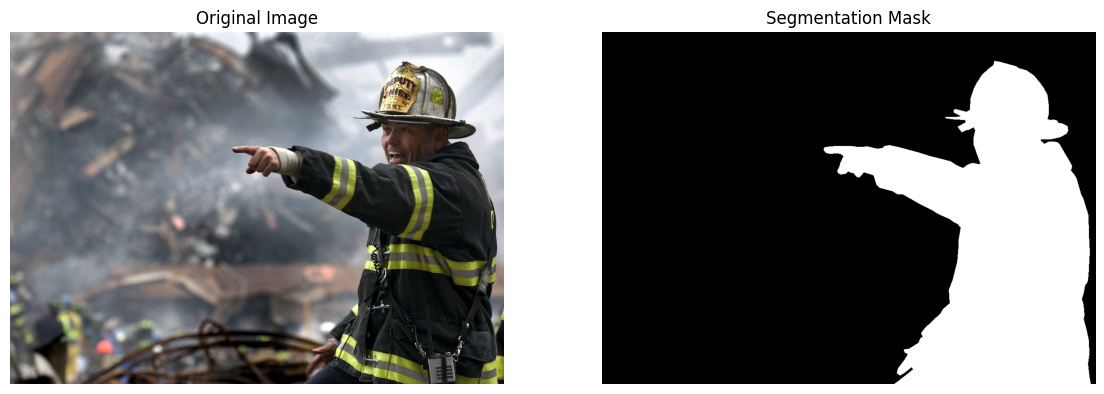

In [3]:
image_path = "../data/human_segmentation_kaggle/images/ds6_fireman-firefighter-rubble-9-11-70573.png"
mask_path = "../data/human_segmentation_kaggle/masks/ds6_fireman-firefighter-rubble-9-11-70573.png"

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_width, original_height = original_image.shape[:2]

original_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(14, 8))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# Plot binary mask
plt.subplot(1, 2, 2)
plt.imshow(original_mask, cmap='gray')
plt.title("Segmentation Mask")
plt.axis('off')

plt.show()

input_image = cfg.IMAGE_TRANSFORMS(original_image)
input_image = input_image.unsqueeze(0).to("cuda") # create a mini-batch as expected by the model

### Perform inference and overlay segmentation mask over original image

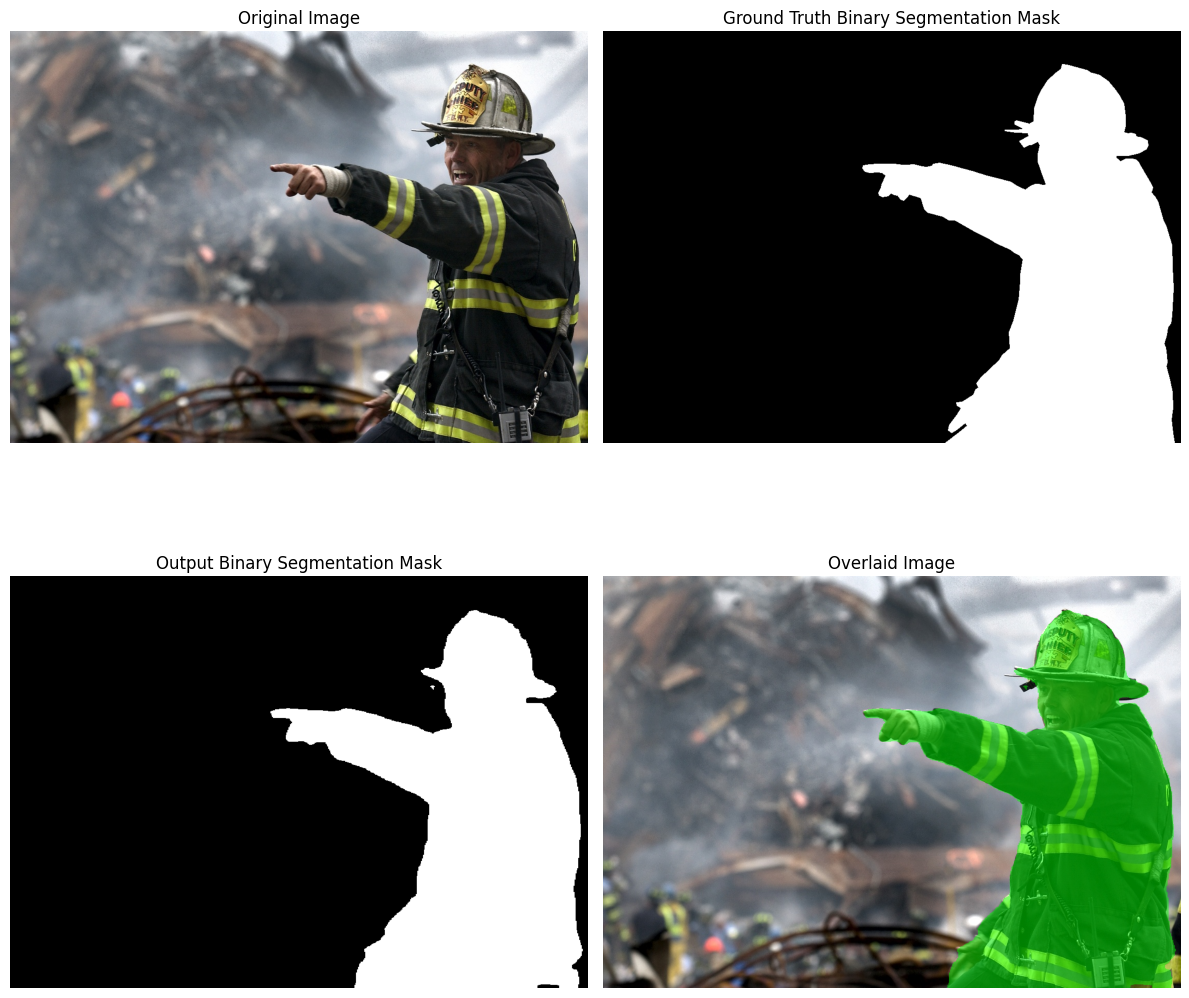

In [4]:
# Get model output logits
logits = inference_model(input_image)['out'][0]  # Get the first item in the batch if in batch mode

# Apply sigmoid to get probabilities, then threshold to get binary mask
probabilities = torch.sigmoid(logits)
binary_mask = probabilities > cfg.THRESHOLD

# Convert binary mask to CPU and numpy array
binary_mask = binary_mask.squeeze().cpu().numpy()  # Remove channel dimension

# Resize the mask to fit the original image dimensions
resized_mask = cv2.resize((binary_mask.astype(np.uint8)) * 255, (original_height, original_width), interpolation=cv2.INTER_NEAREST)

# Convert the input image to a format that matplotlib can display
input_image_display = to_pil_image(original_image)  # Convert to PIL image

# Define transparency factor
alpha = 0.5

# Create an image of the same size as the original image, filled with green
green_overlay = np.zeros_like(original_image, dtype=np.uint8)
green_overlay[:] = (0, 255, 0)  # OpenCV uses BGR format

# Make a copy of the original image to overlay the mask
overlaid_image = original_image.copy()

# Create a boolean mask where the binary mask is active
mask_bool = resized_mask == 255

# For each pixel where mask is True, blend the original image with the green overlay
# Using cv2.addWeighted on the masked regions ensures only those pixels are affected.
overlaid_image[mask_bool] = cv2.addWeighted(original_image[mask_bool], 1 - alpha, green_overlay[mask_bool], alpha, 0)

# Plot original image and binary mask
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()  # Now axes is a 1D array of Axes objects

axes[0].imshow(input_image_display)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(original_mask, cmap="gray")
axes[1].set_title("Ground Truth Binary Segmentation Mask")
axes[1].axis("off")

axes[2].imshow(resized_mask, cmap="gray")
axes[2].set_title("Output Binary Segmentation Mask")
axes[2].axis("off")

axes[3].imshow(overlaid_image)
axes[3].set_title("Overlaid Image")
axes[3].axis("off")

plt.tight_layout()
plt.show()